In [1]:
# Import Libraries;
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
#from keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os

In [2]:
# Path to the image dataset folder
image_folder = 'trainA'

In [3]:
# Function to load images from the folder
def load_images_from_folder(folder, target_size=(32, 32)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize to target size
            img = img.astype('float32') / 255.  # Normalize the image
            images.append(img)
    return np.array(images)

In [4]:
# Load images from the folder
underwater_images = load_images_from_folder(image_folder)

In [5]:
# Augment the images to create more samples
def augment_images(images, num_samples=100):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    for img in images:
        img = img.reshape((1,) + img.shape)
        i = 0
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            i += 1
            if i >= num_samples:
                break
    return np.array(augmented_images)

In [6]:
# Augment the images
augmented_images = augment_images(underwater_images)

In [7]:
# Add random noise to the images
noise_factor = 0.5
noisy_images = augmented_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=augmented_images.shape)

In [8]:
# Clip the images to be in the range [0, 1]
noisy_images = np.clip(noisy_images, 0., 1.)

In [9]:
# Split the data into training and validation sets
x_train, x_val, x_train_noisy, x_val_noisy = train_test_split(augmented_images, noisy_images, test_size=0.2, random_state=42)

In [10]:
# Build the autoencoder
input_img = Input(shape=(32, 32, 3))

In [11]:
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [12]:
# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
# Train the autoencoder with validation
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=50,
                          batch_size=10,
                          shuffle=True,
                          validation_data=(x_val_noisy, x_val))

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5580 - val_loss: 0.5031
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5038 - val_loss: 0.5008
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5023 - val_loss: 0.4986
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5016 - val_loss: 0.4985
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5013 - val_loss: 0.4988
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4996 - val_loss: 0.4974
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5004 - val_loss: 0.4973
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4993 - val_loss: 0.4972
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4975 - val_loss: 0.4975
Epoch 10/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4987 - val_loss: 0.4983
Epoch 11/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4983 - val_loss: 0.4971
Epoch 12/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

In [14]:
# Predict the denoised images
denoised_images = autoencoder.predict(x_val_noisy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [15]:
# Calculate Mean Squared Error (MSE) between original and denoised images
mse = mean_squared_error(x_val.flatten(), denoised_images.flatten())
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.006732599809765816


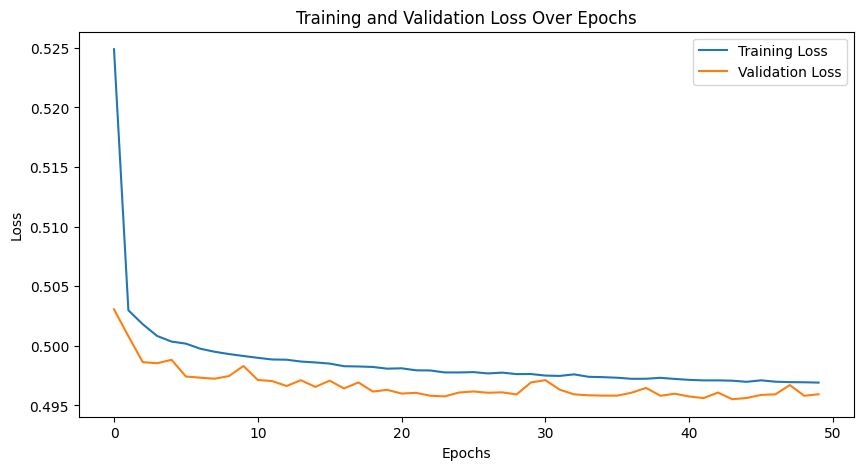

In [16]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

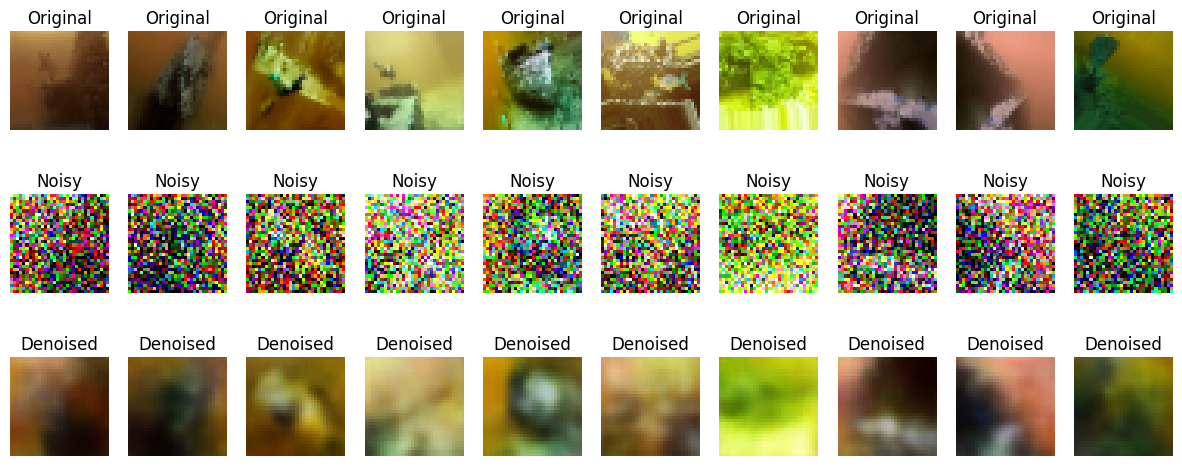

In [17]:
# Display the original, noisy, and denoised images
n = 10  # Display first 10 images
plt.figure(figsize=(15, 6))

for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val[i])
    plt.title("Original")
    plt.axis('off')

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_val_noisy[i])
    plt.title("Noisy")
    plt.axis('off')

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i])
    plt.title("Denoised")
    plt.axis('off')

plt.show()